In [ ]:
# pip install  statsmodels

In [22]:
import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
from matplotlib import gridspec

# Задача 1

### Загрузка данных

In [23]:
gdp = pd.read_excel(r'real_gdp_usa.xlsx', index_col=0)
gdp.index = pd.PeriodIndex(gdp.index.str.replace(':', 'q'), freq='Q') # превращаем индекс в удобный формат
gdp

,gdp
date,
1947Q1,1772.2
1947Q2,1769.5
1947Q3,1768.0
1947Q4,1794.8
1948Q1,1823.4
...,...
2009Q4,13019.0
2010Q1,13138.8
2010Q2,13194.9


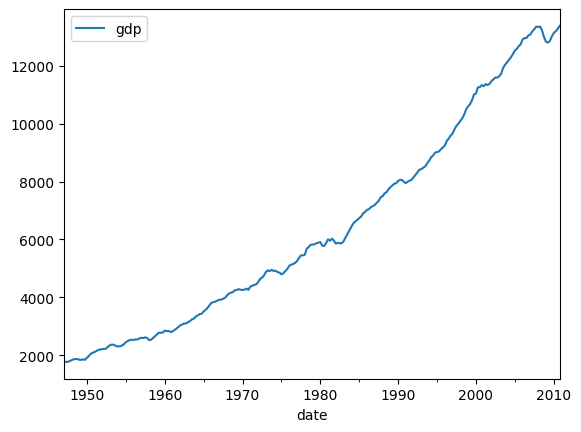

In [24]:
gdp.plot();

### Разложение ряда на компоненты

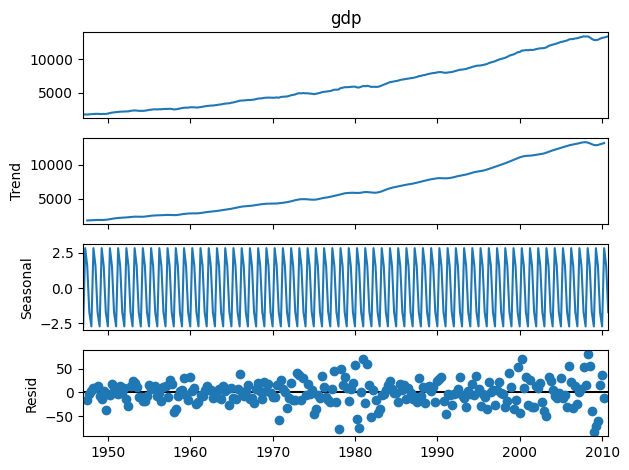

In [25]:
gdp.index = gdp.index.to_timestamp()
sd = seasonal_decompose(gdp['gdp'])
sd.plot();

In [26]:
pd.concat([sd.observed, sd.trend, sd.seasonal, sd.resid], axis=1)

,gdp,trend,seasonal,resid
date,,,,
1947-01-01,1772.2,NaN,-2.711458,NaN
1947-04-01,1769.5,NaN,2.837946,NaN
1947-07-01,1768.0,1782.5250,1.574058,-16.099058
1947-10-01,1794.8,1799.8500,-1.700546,-3.349454
1948-01-01,1823.4,1823.1375,-2.711458,2.973958
...,...,...,...,...
2009-10-01,13019.0,13005.2625,-1.700546,15.438046
2010-01-01,13138.8,13105.5875,-2.711458,35.923958
2010-04-01,13194.9,13203.2500,2.837946,-11.187946


### Тесты на стационарность

In [28]:
def adf_test(timeseries, maxlag=None, regression='c', autolag='AIC'):
    '''
    regression='c' -> регрессия с константой
    AIC -> критерий Акаике
    BIC -> 
    '''
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, maxlag=maxlag, regression=regression, autolag=autolag)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries, maxlag='auto', regression='c'):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression=regression, nlags=maxlag)
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [29]:
adf_test(gdp, maxlag=10, regression='c', autolag='BIC')

Results of Dickey-Fuller Test:
Test Statistic                   1.926683
p-value                          0.998570
#Lags Used                       2.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


In [30]:
adf_test(gdp, maxlag=10, regression='c', autolag='AIC')

Results of Dickey-Fuller Test:
Test Statistic                   2.197405
p-value                          0.998880
#Lags Used                       3.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


In [31]:
kpss_test(gdp, regression='c')
# у КПСС-теста обратная нулевая гипотеза

Results of KPSS Test:
Test Statistic            2.339666
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/var/folders/kn/wk_gspxn3dl6_5x56s3qj_c80000gn/T/ipykernel_1907/1373253521.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression=regression, nlags=maxlag)


$p-value_{ADF} > 0.05, p-value_{KPSS} < 0.05 \Rightarrow$ ряд нестационарен

Вычтем из ряда тренд и проведём тест ещё раз:

In [32]:
t = gdp['gdp'] - sd.trend
adf_test(t.dropna(), maxlag=10, regression='c', autolag='BIC')

Results of Dickey-Fuller Test:
Test Statistic                -9.513328e+00
p-value                        3.205743e-16
#Lags Used                     7.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


In [33]:
adf_test(t.dropna(), maxlag=10, regression='c', autolag='AIC')

Results of Dickey-Fuller Test:
Test Statistic                -9.513328e+00
p-value                        3.205743e-16
#Lags Used                     7.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


In [34]:
kpss_test(t.dropna(), regression='c')
# стандартный диапазон критических значений указан для p-value от 1% до 10%, поэтому warning

Results of KPSS Test:
Test Statistic            0.02738
p-value                   0.10000
Lags Used                14.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


/var/folders/kn/wk_gspxn3dl6_5x56s3qj_c80000gn/T/ipykernel_1907/1373253521.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression=regression, nlags=maxlag)


$p-value_{ADF} < 0.05, p-value_{KPSS} > 0.05 \Rightarrow$ ряд стационарен. Стационарный в первых разностях ряд соответствует порядку интегрированности 1

## Задача 2

In [35]:
ppp = pd.read_csv('ppp.csv')
ppp

,obs,CPIFR,CPIIT,LNFR,LNIT,LNP,LNX
0,1981M01,57.8451,43.5,4.057769,3.772761,-0.285008,5.331368
1,1981M02,58.3893,44.3,4.067133,3.790985,-0.276148,5.325063
2,1981M03,58.9334,45.0,4.076408,3.806662,-0.269746,5.354162
3,1981M04,59.7497,45.6,4.090164,3.819908,-0.270256,5.352268
4,1981M05,60.2939,46.3,4.099231,3.835142,-0.264089,5.342614
...,...,...,...,...,...,...,...
181,1996M02,113.1094,131.3,4.728355,4.877485,0.149129,5.710837
182,1996M03,113.8095,131.7,4.734526,4.880527,0.146001,5.721028
183,1996M04,114.0095,132.5,4.736282,4.886583,0.150301,5.698603
184,1996M05,114.2095,133.0,4.738034,4.890349,0.152315,5.684048


In [36]:
ppp.LNX + ppp.LNFR - ppp.LNIT
# log exchange rate france/italy + log price index france - log italy

0      5.616375
1      5.601210
2      5.623908
3      5.622524
4      5.606703
         ...   
181    5.561708
182    5.575028
183    5.548303
184    5.531733
185    5.527260
Length: 186, dtype: float64

<Axes: xlabel='obs'>

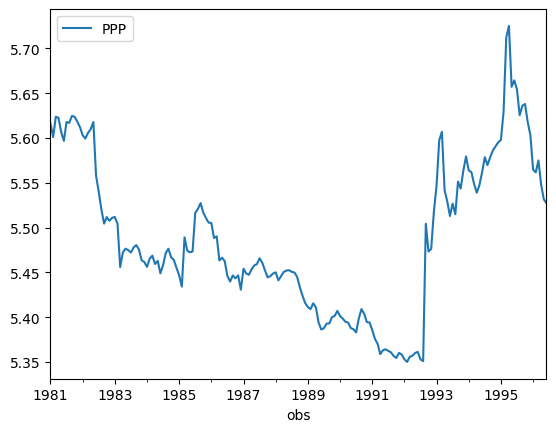

In [37]:
pppTS = pd.DataFrame(
    ppp.LNX + ppp.LNFR - ppp.LNIT, columns=['PPP']
)
pppTS.index=pd.to_datetime(ppp.obs.str.replace('M', '-'))
pppTS.plot()

In [38]:
adf_test(pppTS)

Results of Dickey-Fuller Test:
Test Statistic                  -1.929649
p-value                          0.318244
#Lags Used                       0.000000
Number of Observations Used    185.000000
Critical Value (1%)             -3.466201
Critical Value (5%)             -2.877293
Critical Value (10%)            -2.575168
dtype: float64


$p-value \geq 0.05 \Rightarrow$ ряд нестационарен

# Задача 3

In [39]:
from statsmodels.tsa.filters.hp_filter import hpfilter

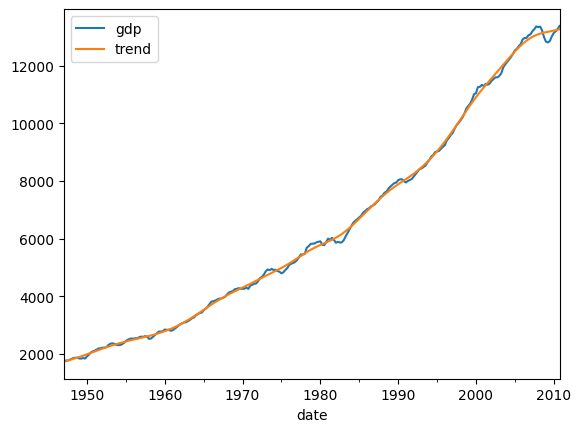

In [40]:
gdp_hp = gdp.copy()
gdp_hp['cycle'], gdp_hp['trend'] = hpfilter(gdp, lamb=1600)
gdp_hp[['gdp', 'trend']].plot();

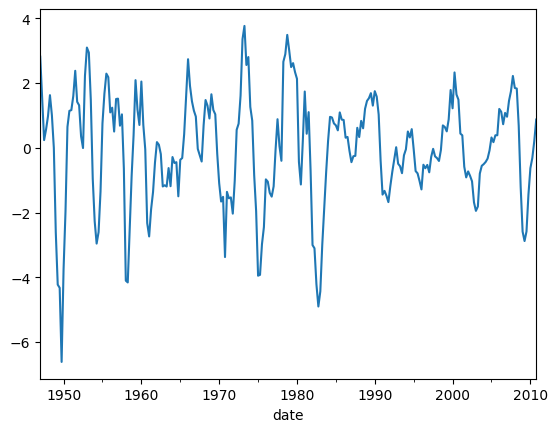

In [41]:
gda = gdp_hp['cycle'] / gdp_hp['gdp'] * 100
gda.plot();

In [41]:
adf_test(gdp_hp['cycle'])

Results of Dickey-Fuller Test:
Test Statistic                -7.120717e+00
p-value                        3.728798e-10
#Lags Used                     1.000000e+01
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


In [42]:
kpss_test(gdp_hp['cycle'])
# по обоим тестам получаем, что ряд стационарен

Results of KPSS Test:
Test Statistic           0.014853
p-value                  0.100000
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/var/folders/kn/wk_gspxn3dl6_5x56s3qj_c80000gn/T/ipykernel_1907/1373253521.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression=regression, nlags=maxlag)


# Задача 4

In [43]:
D = pd.read_excel('ARIMA_example.xlsx')
D

,y1,y2,y3
0,19.916475,5.007638,1.000000
1,19.980078,4.983601,0.899422
2,19.857470,5.024198,0.750124
3,19.953421,5.055578,0.802100
4,20.114684,5.214623,0.637604
...,...,...,...
495,20.139147,5.159028,-0.890206
496,20.077150,4.855972,-0.958143
497,20.115524,5.221188,-0.903991
498,20.023801,4.676370,-0.936263


In [44]:
D.describe()

,y1,y2,y3
count,500.000000,500.000000,500.000000
mean,19.991293,5.001028,-0.022415
std,0.118879,0.128549,0.408578
min,19.606119,4.633757,-1.102351
25%,19.914387,4.917619,-0.306515
50%,19.995489,5.006304,-0.036988
75%,20.077765,5.082084,0.255438
max,20.317500,5.439992,1.191098


Среднее рядов y1 и y2 отлично от 0 $\Rightarrow$ нужна константа

<Axes: >

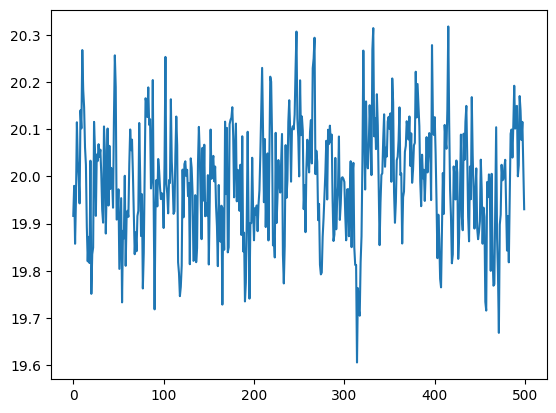

In [45]:
D.y1.plot()

In [46]:
adf_test(D.y1, maxlag=10, regression='c', autolag='BIC') # p-value < 0 - стационарный 

Results of Dickey-Fuller Test:
Test Statistic                -1.211319e+01
p-value                        1.898474e-22
#Lags Used                     0.000000e+00
Number of Observations Used    4.990000e+02
Critical Value (1%)           -3.443523e+00
Critical Value (5%)           -2.867350e+00
Critical Value (10%)          -2.569864e+00
dtype: float64


In [47]:
def corr_plot(df, zero=True):
    fig = plt.figure(figsize=(15, 8))
    gs = gridspec.GridSpec(2, 4)
    gs.update(wspace=0.5)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, :2])
    ax3 = fig.add_subplot(gs[1, 2:])
    df.plot(ax=ax1)
    plot_acf(df, zero=zero, ax=ax2)
    plot_pacf(df, zero=zero, ax=ax3)
    plt.show();


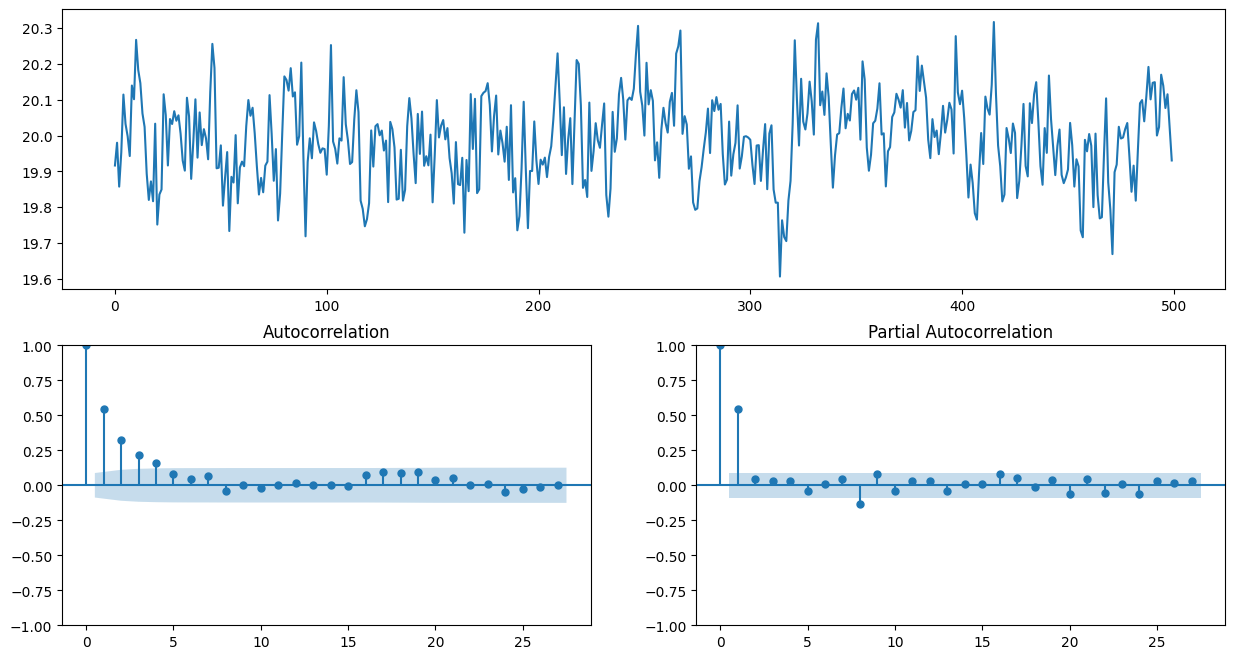

In [48]:
corr_plot(D.y1)
# всегда строится нулевая корреляция, т.е. корреляция ряда с собой

Подберём модель (подозреваем AR(1), но мало ли)

In [50]:
# по частной автокорреляционной функции мы видим, что только первый лаг значимо коррелирует => ARIMA(1,0,0)
m1 = ARIMA(D.y1, order=(1, 0, 0)).fit()
print(m1.summary())

# ar.L1 -- y_{t-1}
# наименьший информационный критерий у ARIMA(1,0,0) => она наилучшая

                               SARIMAX Results                                
Dep. Variable:                     y1   No. Observations:                  500
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 443.531
Date:                Sat, 25 Nov 2023   AIC                           -881.063
Time:                        14:47:57   BIC                           -868.419
Sample:                             0   HQIC                          -876.102
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.9910      0.010   2048.889      0.000      19.972      20.010
ar.L1          0.5436      0.039     13.790      0.000       0.466       0.621
sigma2         0.0099      0.001     15.347      0.0

Ljung-Box: $H_0:$ остатки - белый шум. Гипотеза не отвергается

Heteroskedasticity: $H_0:$ остатки гомоскедастичны (тест Уайта). Гипотеза не отвергается

Jarque-Bera: $H_0:$ остатки распределены нормально. Гипотеза не отвергается

In [51]:
adf_test(m1.resid) # остатки не итегрированы
# получили адекватную ARIMA-модель (см. p-value)

Results of Dickey-Fuller Test:
Test Statistic                -7.823863e+00
p-value                        6.560503e-12
#Lags Used                     7.000000e+00
Number of Observations Used    4.920000e+02
Critical Value (1%)           -3.443711e+00
Critical Value (5%)           -2.867432e+00
Critical Value (10%)          -2.569908e+00
dtype: float64


In [53]:
print(
    ARIMA(D.y1, order=(2, 0, 0))
    .fit()
    .summary()
)

                               SARIMAX Results                                
Dep. Variable:                     y1   No. Observations:                  500
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 443.998
Date:                Sat, 25 Nov 2023   AIC                           -879.996
Time:                        14:48:13   BIC                           -863.137
Sample:                             0   HQIC                          -873.381
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.9909      0.010   1957.966      0.000      19.971      20.011
ar.L1          0.5201      0.046     11.299      0.000       0.430       0.610
ar.L2          0.0431      0.043      1.006      0.3

In [54]:
print(
    ARIMA(D.y1, order=(3, 0, 0))
    .fit()
    .summary()
)

                               SARIMAX Results                                
Dep. Variable:                     y1   No. Observations:                  500
Model:                 ARIMA(3, 0, 0)   Log Likelihood                 444.238
Date:                Sat, 25 Nov 2023   AIC                           -878.477
Time:                        14:48:23   BIC                           -857.404
Sample:                             0   HQIC                          -870.208
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.9909      0.011   1897.063      0.000      19.970      20.012
ar.L1          0.5187      0.046     11.231      0.000       0.428       0.609
ar.L2          0.0269      0.049      0.548      0.5

In [55]:
print(
    ARIMA(D.y1, order=(0, 0, 1))
    .fit()
    .summary()
)

                               SARIMAX Results                                
Dep. Variable:                     y1   No. Observations:                  500
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 421.346
Date:                Sat, 25 Nov 2023   AIC                           -836.692
Time:                        14:49:27   BIC                           -824.049
Sample:                             0   HQIC                          -831.731
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.9912      0.007   2972.522      0.000      19.978      20.004
ma.L1          0.4431      0.041     10.939      0.000       0.364       0.522
sigma2         0.0108      0.001     15.787      0.0

In [56]:
print(
    ARIMA(D.y1, order=(0, 0, 2))
    .fit()
    .summary()
)

                               SARIMAX Results                                
Dep. Variable:                     y1   No. Observations:                  500
Model:                 ARIMA(0, 0, 2)   Log Likelihood                 437.037
Date:                Sat, 25 Nov 2023   AIC                           -866.075
Time:                        14:49:43   BIC                           -849.216
Sample:                             0   HQIC                          -859.459
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.9911      0.008   2530.600      0.000      19.976      20.007
ma.L1          0.5201      0.045     11.510      0.000       0.431       0.609
ma.L2          0.2278      0.044      5.151      0.0

И MA(1), и MA(2) показывают значимость всех коэффициентов, но мы всё равно выбираем AR(1). Почему?

In [57]:
FC = m1.get_forecast(steps=10)
FC.summary_frame()

y1,mean,mean_se,mean_ci_lower,mean_ci_upper
500,19.958121,0.099619,19.762871,20.153371
501,19.973111,0.113387,19.750876,20.195346
502,19.981260,0.117146,19.751657,20.210863
503,19.985690,0.118235,19.753954,20.217425
504,19.988098,0.118554,19.755736,20.220460
505,19.989407,0.118648,19.756860,20.221954
506,19.990118,0.118676,19.757517,20.222720
507,19.990505,0.118685,19.757888,20.223123
508,19.990716,0.118687,19.758093,20.223338
509,19.990830,0.118688,19.758206,20.223454


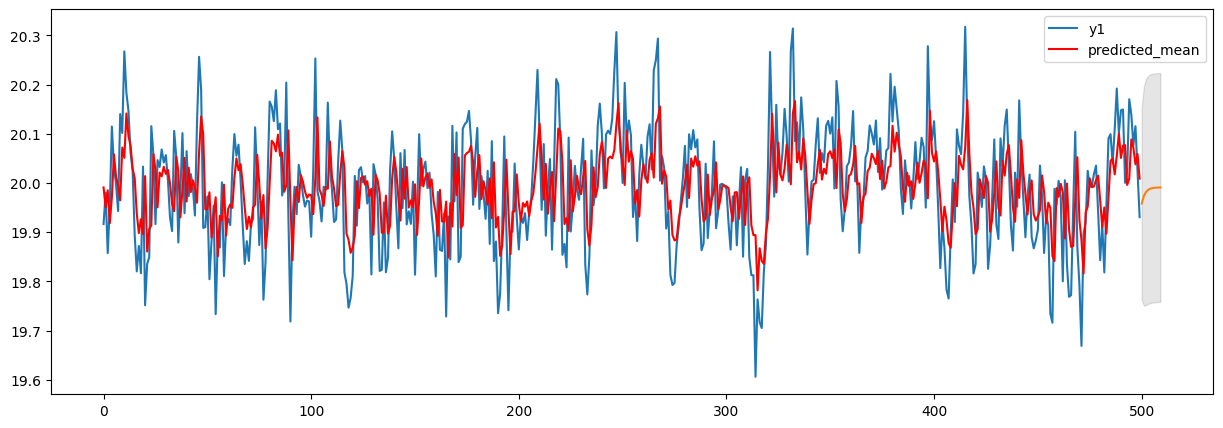

In [58]:
fcast = FC.summary_frame()
fig, ax = plt.subplots(figsize=(15, 5))
D.y1.plot(ax=ax, legend=True)
fcast['mean'].plot(ax=ax, )
ax.fill_between(
    fcast.index, 
    fcast['mean_ci_lower'], 
    fcast['mean_ci_upper'], 
    color='k', 
    alpha=0.1
);
m1.predict().plot(ax=ax, color='red', legend=True)
plt.show();

### Pseudo out-of-sample predictions

цикл для процедуры pseudo out-of-sample прогноза, как в лекции 

оцениваем на 1-400 наблюдении, прогноз на 401е, считаем RMSE

оцениваем на 1-401 наблюдении, прогноз на 402е, считаем RMSE и т.д. до 500-го

In [59]:
def RMSE(y1, y2):
    return np.linalg.norm(y1 - y2, ord=2) / np.sqrt(len(y1))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


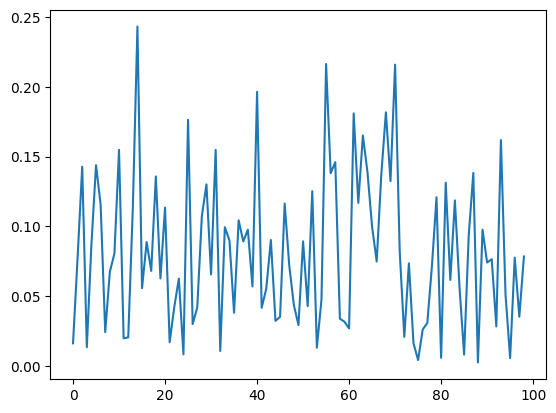

In [60]:
resultRMSE = np.array([]) #пустой массив для записи результатов
for i in range(401, 500):
    resultRMSE = np.append(
        resultRMSE, 
        RMSE(D.y1[[i]], 
             ARIMA(D.y1[:i], order=(1, 0, 0)).fit().forecast(1).values)
        )
plt.plot(resultRMSE);

'''
resultRMSE1 = np.array([]) #пустой массив для записи результатов
for i in range(401, 490):
    resultRMSE = np.append(
        resultRMSE, 
        RMSE(D.y1[[i]], 
             ARIMA(D.y1[:i], order=(1, 0, 0)).fit().forecast(10).values)
        )
plt.plot(resultRMSE1);
'''

In [ ]:
resultRMSE1 = np.array([]) #пустой массив для записи результатов
for i in range(401, 490):
    resultRMSE1 = np.append(
        resultRMSE1, 
        RMSE(D.y1[[i]], 
             ARIMA(D.y1[:i], order=(1, 0, 0)).fit().forecast(10).values)
        )
plt.plot(resultRMSE1);

Для сравнения посчитаем RMSE MA(1) процесса:

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


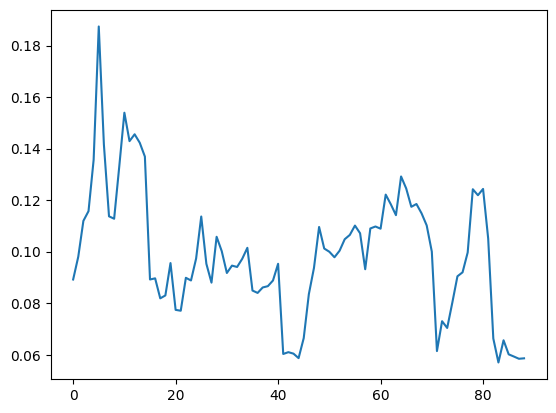

In [67]:
resultRMSE_MA = np.array([]) #пустой массив для записи результатов
for i in range(401, 490):
    resultRMSE_MA = np.append(
        resultRMSE_MA, 
        RMSE(D.y1[i:i+10], 
             ARIMA(D.y1[i:i+10], order=(0, 0, 1)).fit().forecast(10).values)
        )
plt.plot(resultRMSE_MA);

In [34]:
print(f'RMSE AR(1)-процесса: {resultRMSE.mean()} \nRMSE MA(1)-процесса: {resultRMSE_MA.mean()}')

RMSE AR(1)-процесса: 0.08160059631260855 
RMSE MA(1)-процесса: 0.08277049874370981


### Зачем мы всё это делали: auto arima

In [68]:
# pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 656.2/656.2 kB 3.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 7.3 MB/s eta 0:00:00a 0:00:01m
Note: you may need to restart the kernel to use updated packages.


In [69]:
from pmdarima.arima import auto_arima
print(auto_arima(D.y1).summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 443.531
Date:                Sat, 25 Nov 2023   AIC                           -881.062
Time:                        15:13:06   BIC                           -868.419
Sample:                             0   HQIC                          -876.101
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.1108      0.788     11.567      0.000       7.567      10.655
ar.L1          0.5443      0.039     13.811      0.000       0.467       0.621
sigma2         0.0099      0.001     15.351      0.0

# Задача 6

In [73]:
# pip install yfinance

In [74]:
import yfinance as yf
GOOG = yf.download('GOOG', start = '2019-01-01', end='2019-10-11')
#GOOG = pd.read_csv('google.csv')
GOOG

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,50.828499,52.616001,50.785500,52.292500,52.292500,30652000
2019-01-03,52.049999,52.848999,50.703499,50.803001,50.803001,36822000
2019-01-04,51.629501,53.542000,51.370899,53.535500,53.535500,41878000
2019-01-07,53.575001,53.700001,52.737999,53.419498,53.419498,39638000
2019-01-08,53.805500,54.228001,53.026501,53.813999,53.813999,35298000
...,...,...,...,...,...,...
2019-10-04,59.594501,60.571999,59.458500,60.450001,60.450001,23248000
2019-10-07,60.220001,60.910198,60.187500,60.383999,60.383999,16858000
2019-10-08,59.879501,60.304001,59.450500,59.456501,59.456501,20786000


In [ ]:
'''
SIBN = yf.download('SIBN', start = '2023-01-01', end='2023-10-11')
SIBN
'''

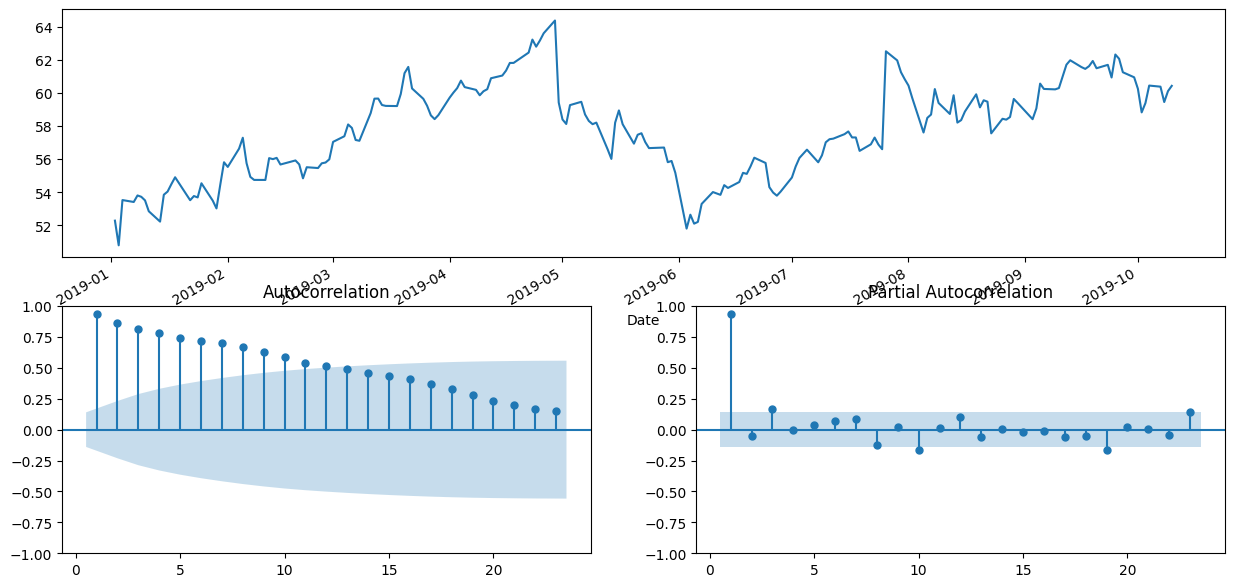

In [77]:
z = GOOG.Close
corr_plot(z, zero=False)

In [80]:
adf_test(z, maxlag=10, regression='c', autolag='BIC')

Results of Dickey-Fuller Test:
Test Statistic                  -2.689264
p-value                          0.075914
#Lags Used                       0.000000
Number of Observations Used    195.000000
Critical Value (1%)             -3.464337
Critical Value (5%)             -2.876479
Critical Value (10%)            -2.574733
dtype: float64


In [81]:
best_model = auto_arima(z[:-10])
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  186
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -256.419
Date:                Sat, 25 Nov 2023   AIC                            514.839
Time:                        15:22:33   BIC                            518.059
Sample:                             0   HQIC                           516.144
                                - 186                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.9363      0.039     23.964      0.000       0.860       1.013
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):               839.08
Prob(Q):                              0.67   Pr

Построим прогноз

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


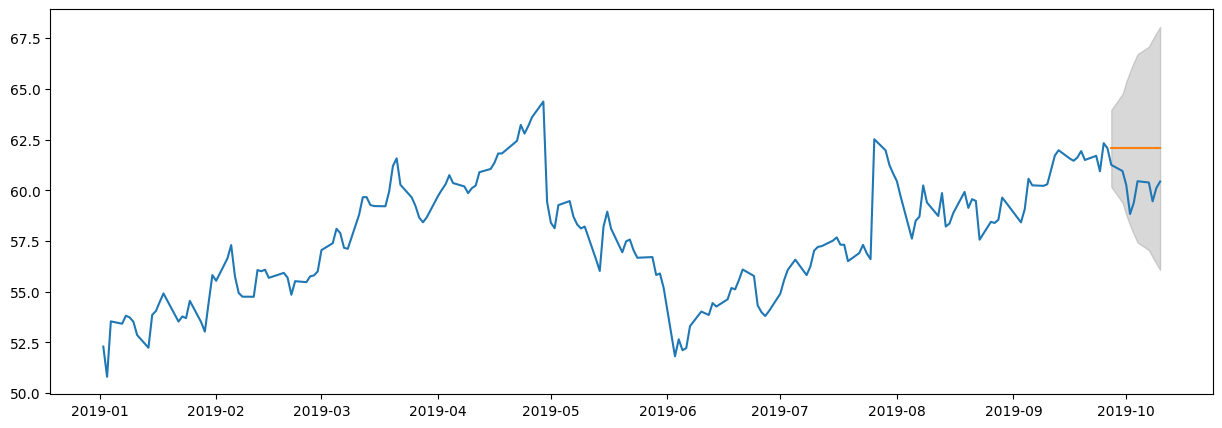

In [83]:
prediction, conf_int = best_model.predict(n_periods=10, return_conf_int=True) # forecast здесь назвается predict'ом
cf = pd.DataFrame(conf_int)
prediction.index = z[-10:].index
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(z)
ax.plot(prediction)
ax.fill_between(prediction.index,
                cf[0], 
                cf[1], color='grey', alpha=.3)
plt.plot();

Покажем, что ARIMA(0,1,0) эквивалентна ARIMA(0, 0, 0) для разностей

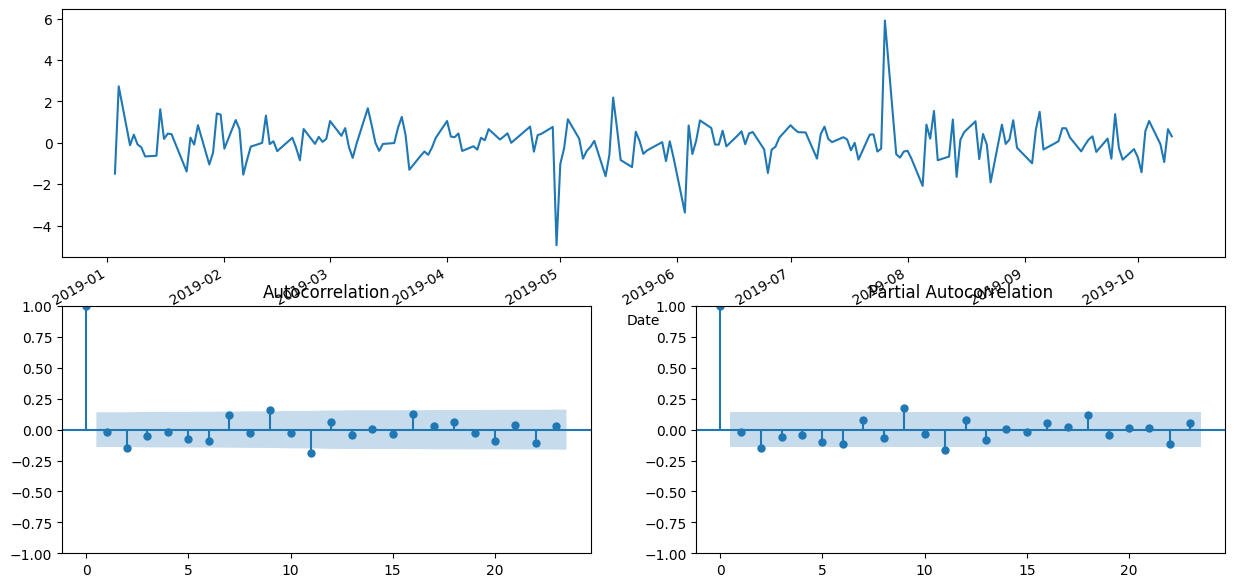

In [85]:
corr_plot(z.diff().dropna())

In [86]:
print(auto_arima(z[:-10].diff().dropna()).summary())
# ARIMA(0,1,0) плохо описывает данные
# (см. большой куртосис, отвержение нормальности остатков [Prob(JB)])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  185
Model:                        SARIMAX   Log Likelihood                -256.419
Date:                Sat, 25 Nov 2023   AIC                            514.839
Time:                        15:30:36   BIC                            518.059
Sample:                             0   HQIC                           516.144
                                - 185                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.9363      0.039     23.964      0.000       0.860       1.013
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):               839.08
Prob(Q):                              0.67   Pr

Проблемы оценки:

1. Гетероскедастичность: p-value=0.05 - на грани отвержения гипотезы о постоянстве дисперсий остатков.

2. Тест Харке-Бера: нормальность остатков отвергается, эксцесс сильно больше 3.

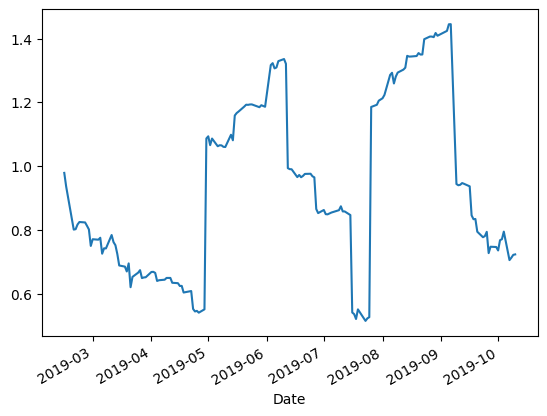

In [87]:
resids = auto_arima(z.diff().dropna()).resid()
stds = resids.rolling(30).std()
stds.plot();

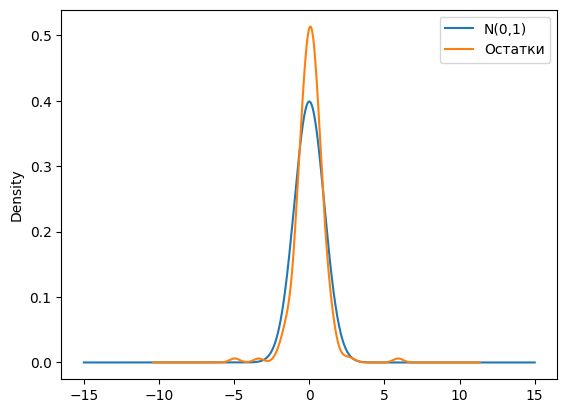

In [88]:
from scipy.stats import norm

# N(0,1)
x = np.linspace(-15, 15, 10000)
plt.plot(x, norm(0,1).pdf(x), label='N(0,1)') # плотность нормаольного распределения

#Распределение
resids.plot.kde(label='Остатки')
plt.legend()
plt.show()
# видим большой эксцесс

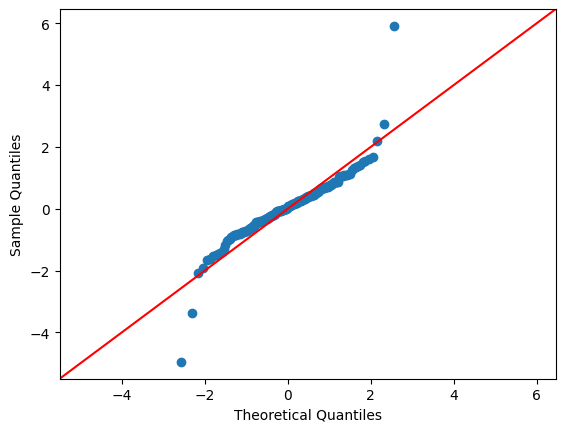

In [89]:
from statsmodels.graphics.gofplots import qqplot
qqplot(resids, line='45');
# тяжелые хвосты => нет нормальности остатков
# ARIMA не помогает!